In [1]:
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


# 프로젝트: CIFAR-10 이미지 생성하기
## 데이터셋 구성하기

- 학습에 사용할 train_x의 이미지를 \[-1, 1\]로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [3]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
# reshape 필요 없겠네
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


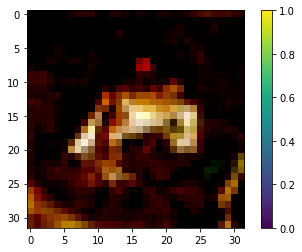

In [6]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

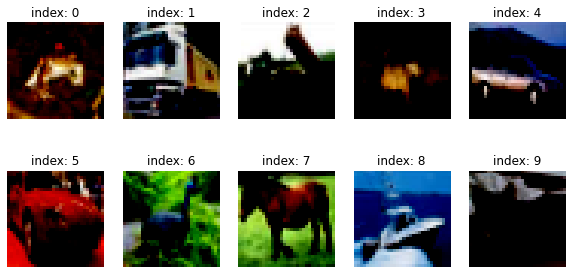

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal(\[1, 100\])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [64]:
def make_generator_model(activation = layers.LeakyReLU()):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(activation)

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(activation)

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(activation)

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

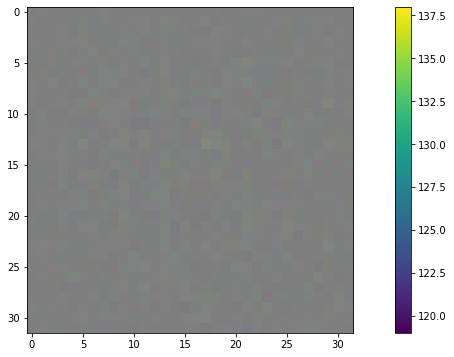

In [32]:
generated_image_int = ((generated_image.numpy()*127.5)+127.5).astype(int)
plt.imshow(generated_image_int[0])
plt.colorbar()
plt.show()

## 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [107]:
def make_discriminator_model(activation=layers.LeakyReLU(), dropout_rate=0.3):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))

    model.add(activation)
    model.add(layers.Dropout(dropout_rate))


    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    
    model.add(activation)
    model.add(layers.Dropout(dropout_rate))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [97]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   multiple                  0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00169966]], dtype=float32)>

## 손실함수와 최적화함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [22]:
gen_learning_rate = 1e-4
disc_learning_rate = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [77]:
@tf.function
def train_step(images,generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,
generator = generator, discriminator = discriminator):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산|
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [33]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        predictions_int = ((predictions.numpy()*127.5)+127.5).astype(int)
        plt.imshow(predictions_int[0])
        # plt.imshow(predictions[i, :, :,0])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [27]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [83]:
def make_anim_file(_ver='0'):
    anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan_{}.gif'.format(_ver)

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

## 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요없이 이런 작업을 진행할 수 있습니다.    
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [111]:
def train(dataset, epochs, save_every, checkpoint_prefix = checkpoint_prefix, generator_optimizer= generator_optimizer, discriminator_optimizer=discriminator_optimizer,
generator = generator, discriminator = discriminator):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch, generator_optimizer,discriminator_optimizer, generator = generator, discriminator = discriminator)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 50

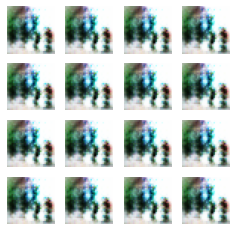

Time for training : 626 sec


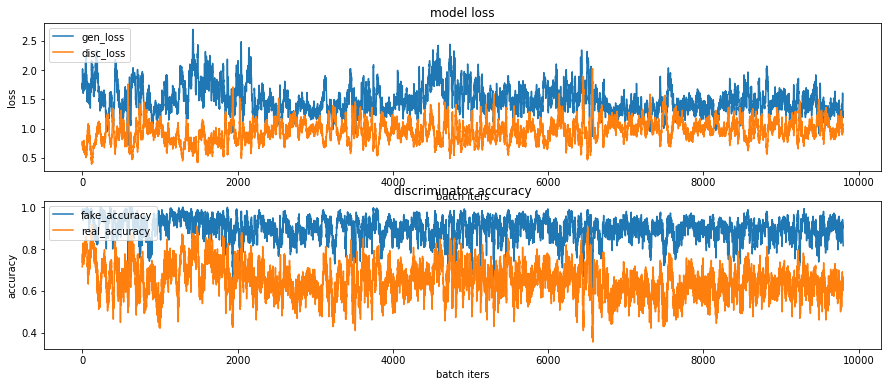

CPU times: user 10min 23s, sys: 17.6 s, total: 10min 41s
Wall time: 10min 26s


In [34]:
%%time
train(train_dataset, EPOCHS, save_every,checkpoint_prefix, generator_optimizer, discriminator_optimizer, generator = generator, discriminator = discriminator)

In [73]:
def load_checkpoint_model(_dir = checkpoint_dir,
generator = generator, discriminator = discriminator): 
    checkpoint_dir = _dir

    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)
    
    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

def show_from_noise(generator = generator):
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
# checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

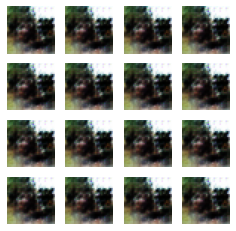

Time for training : 619 sec


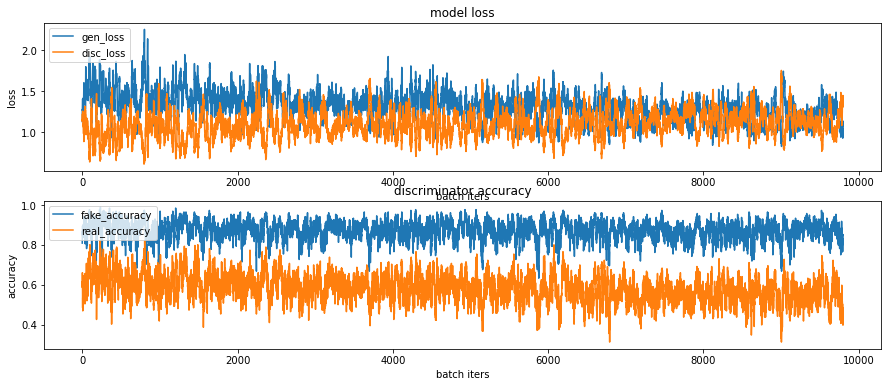

CPU times: user 10min 18s, sys: 17.6 s, total: 10min 35s
Wall time: 10min 20s


In [42]:
%%time
train(train_dataset, EPOCHS, save_every)

In [51]:
load_checkpoint_model(checkpoint_dir)

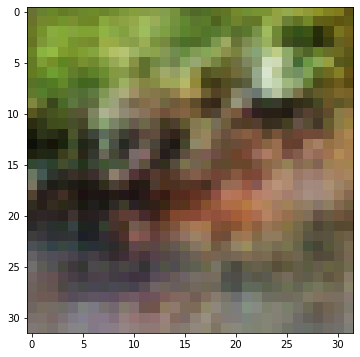

In [53]:
show_from_noise()

## (optional) GAN 훈련 과정 개선하기
- STEP 6을 진행하면서 생성된 샘플 이미지, 학습과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습과정을 개선한 내역과 그 결과(샘플 이미지, 학습과정 그래프 포함)를 함께 제출합니다.

In [56]:
# learning rate 를 바꿔보자
gen_learning_rate_2 = 1e-3
disc_learning_rate_2 = 1e-3
generator_optimizer_2 = tf.keras.optimizers.Adam(gen_learning_rate_2)
discriminator_optimizer_2 = tf.keras.optimizers.Adam(disc_learning_rate_2)

In [57]:
checkpoint_dir_2 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2'

checkpoint_prefix_2 = os.path.join(checkpoint_dir_2, "ckpt")
checkpoint_2 = tf.train.Checkpoint(generator_optimizer=generator_optimizer_2,
                                 discriminator_optimizer=discriminator_optimizer_2,
                                 generator=generator,
                                 discriminator=discriminator)

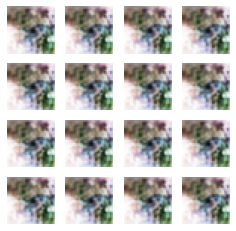

Time for training : 600 sec


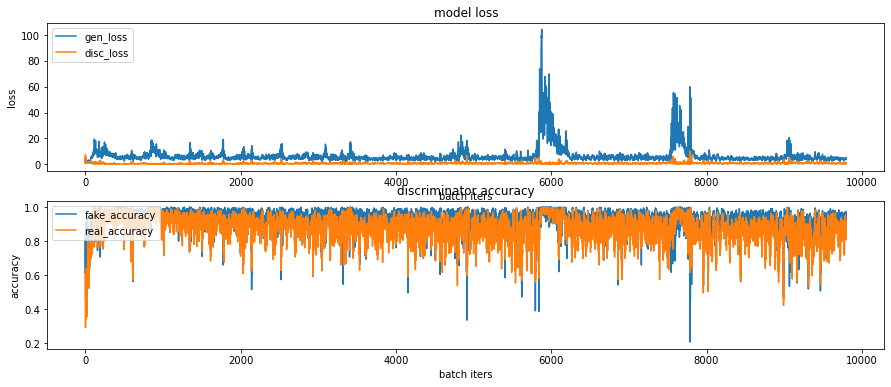

CPU times: user 9min 59s, sys: 18.2 s, total: 10min 17s
Wall time: 10min


In [62]:
%%time
train(train_dataset, EPOCHS, save_every,checkpoint_prefix_2, generator_optimizer_2, discriminator_optimizer_2)

In [66]:
# 모델 구조를 변경해보는건 어떨까?
generator_relu = make_generator_model(activation=layers.ReLU())

generator_relu.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
re_lu_1 (ReLU)               multiple                  0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)       

In [70]:
discriminator_relu_02 = make_discriminator_model(activation=layers.ReLU(), dropout_rate=0.2)

discriminator_relu_02.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
re_lu_2 (ReLU)               multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [112]:
def make_discriminator_model_Batch(activation=layers.LeakyReLU()):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))    
    model.add(layers.BatchNormalization())
    model.add(activation)


    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(activation)

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [115]:
discriminator_relu_Batch = make_discriminator_model_Batch(activation=layers.ReLU())

discriminator_relu_Batch.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_22 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_15 (ReLU)              multiple                  0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_23 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)               

In [114]:
discriminator_relu_04 = make_discriminator_model(activation=layers.ReLU(), dropout_rate=0.4)

discriminator_relu_04.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
re_lu_14 (ReLU)              multiple                  0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)               

In [74]:
gen_learning_rate_3 = 1e-4
disc_learning_rate_3 = 1e-4
generator_optimizer_3 = tf.keras.optimizers.Adam(gen_learning_rate_3)
discriminator_optimizer_3 = tf.keras.optimizers.Adam(disc_learning_rate_3)

checkpoint_dir_3 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_3'

checkpoint_prefix_3 = os.path.join(checkpoint_dir_3, "ckpt")
checkpoint_3 = tf.train.Checkpoint(generator_optimizer=generator_optimizer_3,
                                 discriminator_optimizer=discriminator_optimizer_3,
                                 generator=generator_relu,
                                 discriminator=discriminator_relu_02)

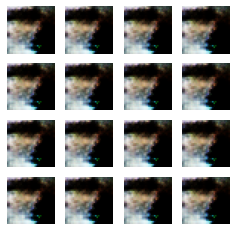

Time for training : 601 sec


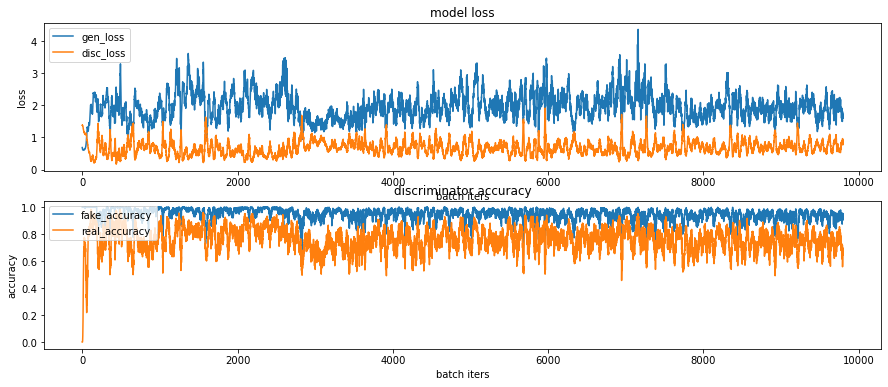

CPU times: user 9min 51s, sys: 22.2 s, total: 10min 13s
Wall time: 10min 2s


In [78]:
%%time
train(train_dataset, EPOCHS, save_every,checkpoint_prefix_3, generator_optimizer_3, discriminator_optimizer_3, generator = generator_relu,discriminator=discriminator_relu_02)

In [84]:
make_anim_file(0)

![./fashion_mnist_dcgan_0.gif](./fashion_mnist_dcgan_0.gif)

별 진전이 없어보인다! 계속 fake accuracy 1.0 부근

learning_rate 는 1e-3으로 하고 Batch norm 써볼까?? 

In [118]:
gen_learning_rate_4 = 1e-3
disc_learning_rate_4 = 1e-3
generator_optimizer_4 = tf.keras.optimizers.Adam(gen_learning_rate_4)
discriminator_optimizer_4 = tf.keras.optimizers.Adam(disc_learning_rate_4)

checkpoint_dir_4 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_4'

checkpoint_prefix_4 = os.path.join(checkpoint_dir_4, "ckpt")
checkpoint_4 = tf.train.Checkpoint(generator_optimizer=generator_optimizer_4,
                                 discriminator_optimizer=discriminator_optimizer_4,
                                 generator=generator_relu,
                                 discriminator=discriminator_relu_Batch)

오류가 난다...

In [119]:
%%time
train(train_dataset, EPOCHS, save_every,checkpoint_prefix_4, generator_optimizer_4, discriminator_optimizer_4, generator = generator_relu,discriminator=discriminator_relu_Batch)

ValueError: in user code:

    <ipython-input-77-5fd775d7dc6c>:25 train_step  *
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:478 apply_gradients  **
        self._create_all_weights(var_list)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:661 _create_all_weights
        _ = self.iterations
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:668 __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:793 iterations
        aggregation=tf_variables.VariableAggregation.ONLY_FIRST_REPLICA)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:997 add_weight
        aggregation=aggregation)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py:743 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:141 make_variable
        shape=variable_shape if variable_shape else None)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:259 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:220 _variable_v1_call
        shape=shape)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:66 getter
        return captured_getter(captured_previous, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:511 invalid_creator_scope
        "tf.function-decorated function tried to create "

    ValueError: tf.function-decorated function tried to create variables on non-first call.


In [ ]:
# load_checkpoint_model(_dir=checkpoint_dir_4,
# generator = generator_relu,discriminator=discriminator_relu_02_Batch)
# show_from_noise(generator = generator_relu,discriminator=discriminator_relu_02_Batch)

In [ ]:
# make_anim_file(1)

## 결과 보고서

(32,32,3) shape를 맞추기 위해 generator 모델에서 첫 dense layer 모양과 reshape 형태 변경

훈련과정에서 image plot 하는데 초록색 계열 색만 나오는 것이 이상했음. 생각해보니 3채널인데 plot 하는 함수는 마지막 3채널 부분에서 0 (첫번째 채널) 값만 보여주고 있는 것임. 물론, 형태는 확인 가능하겠지만 색 확인은 안되기 때문에, checkpoint를 불러오는 예제코드를 참조하여 3채널 이미지를 보여주는 방향으로 수정함.

50번 학습한 이후, checkpoint 모델 불러와서 noise를 토대로 generate 시켜봤는데... 내 눈엔 아직도 noise로 보임. 물론 실시할 때마다 다른 모양이 나오는 것으로 보아! 뭔가 하기는 한 것 같음.

그래서 다시 불러온 모델을 50번 돌려봄.
한 20번쯤 하다보니 그래도 좀 비슷한 모양을 내는 것 같은 느낌이 들기 시작함.

---

하지만, 그래도 만족스러운 결과는 아니었기 때문에... 다른 방법을 시도해볼 수 있는것??
- learning rate 를 0.0001 에서 0.001로 올려보았다. => 오히려 더 안좋은 성과를 낸다! 생성자 모델의 loss도 대폭 상승하는 구간이 보이고, accuracy의 분산이 커졌음.
- 모델을 변경...? relu 쓰고 dropout 낮추기. => 효과없음
- Batchnorm 사용? 오류나서 포기

---

학습시키기가 정말 어렵다!
